# MATH50003 (2022–23)
# Lab 3: Divided differences and dual numbers

This lab explores different discretisations for first and higher derivatives.
In particular we consider the following approximations:
*Forward differences*:
$$
f'(x) ≈ {f(x+h) - f(x) \over h}
$$
*Central differences*:
$$
f'(x) ≈ {f(x+h) - f(x-h) \over 2h}
$$
*Second order differences*:
$$
f''(x) ≈ {f(x+h) - 2f(x) + f(x-h) \over h^2}
$$
We also add to the implementation of `Dual` to enable
automatic differentiation with cos, sin, and division

In [1]:
using Plots, Test
# helper function to avoid trying to take logs of 0 in plots
# use in plots below
nanabs(x) = iszero(x) ? NaN : abs(x)

nanabs (generic function with 1 method)

--------

**Problem 1** Implement central differences
for $f(x) = 1 + x + x^2$ and $g(x) = 1 + x/3 + x^2$, approximating the derivative at $x = 0$.
Plot the absolute errors for `h = 2.0 .^ (0:-1:-60)` and `h = 10.0 .^ (0:-1:-16)`.

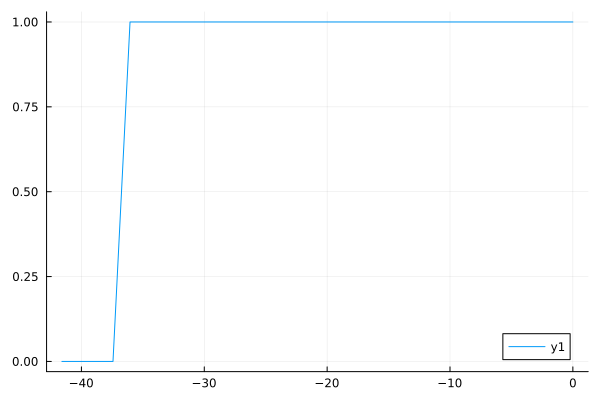

In [32]:
h = 2.0 .^ (0:-1:-60)

numerator = ((ones(61) + h + h .^ 2) - (ones(61) - h + h .^ 2))

approxdf = numerator ./ (2 * h)

#log.(h)

plot(log.(h), approxdf)

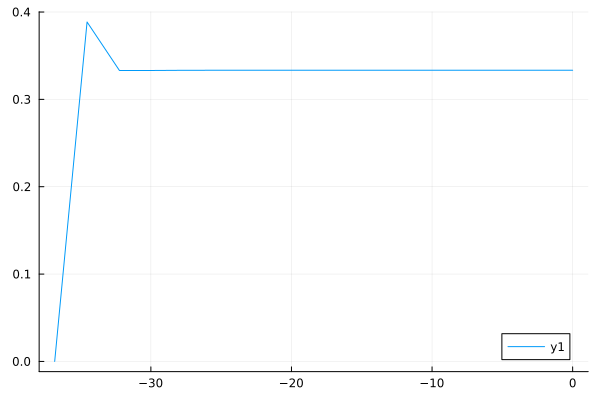

In [33]:
h = 10.0 .^ (0:-1:-16)

approxgf = ((ones(17) + h ./ 3 + h .^ 2) - (ones(17) - h ./ 3 + h .^ 2)) ./ (2 * h)

plot(log.(h), approxgf)

-----
**Problem 2** Use forward differences, central differences, and second-order divided differences to approximate to 5-digits the first and second
derivatives to the following functions
at the point $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + ⋱}}},
$$
e.g.:
$$f^{\rm s}_1(x) = 1 + {x-1 \over 2}$$
$$f^{\rm s}_2(x) = 1 + {x-1 \over 2 + {x -1 \over 2}}$$
$$f^{\rm s}_3(x) = 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}$$

In [64]:
h = 10 ^ -10

fordf = (exp(exp(0.1 + h) * cos(0.1 + h) + sin(0.1 + h)) - exp(exp(0.1) * cos(0.1) + sin(0.1))) / h

cendf = (exp(exp(0.1 + h) * cos(0.1 + h) + sin(0.1 + h)) - exp(exp(0.1 - h) * cos(0.1 - h) + sin(0.1 - h))) / 2h

secdf = (exp(exp(0.1 + h) * cos(0.1 + h) + sin(0.1 + h)) - 
            2 * exp(exp(0.1) * cos(0.1) + sin(0.1)) + 
            exp(exp(0.1 - h) * cos(0.1 - h) + sin(0.1 - h))) / (h ^ 2)
        
#print(fordf, 
#cendf, 
#secdf)

println(fordf)
println(cendf)
println(secdf)

6.58476828618859146.584774947526739-133226.762955018786.5847682861885914
6.584774947526739
-133226.76295501878


In [65]:
h = 10 ^ -10

function g(x)
    prod = 1
    for k in (1:1:1000)
        prod = prod * (x / k - 1)
    end
    prod
end

fordg = (g(0.1 + h) - g(0.1)) / h

cendg = (g(0.1 + h) - g(0.1 -h)) / 2h

secdg = (g(0.1 + h) - 2g(0.1) + g(0.1 - h)) / (h ^ 2)

println(fordg)
println(cendg)
println(secdg)

-3.593824127179346
-3.593822739400565
-27755.57561562891


In [66]:
h = 10 ^ -10

function e(x)
    sum = 1 + (x - 1) / 2
    for i in (1:1:1000)
        sum = 1 + (x - 1) / (2 + sum)
    end
    sum
end

forde = (e(0.1 + h) - e(0.1)) / h

cende = (e(0.1 + h) - e(0.1 -h)) / 2h

secde = (e(0.1 + h) - 2e(0.1) + e(0.1 - h)) / (h ^ 2)

println(forde)
println(cende)
println(secde)

0.4303313261289077
0.4303313261289077
0.0


----

**Problem 3.1** Add support for `cos`, `sin`, and `/` to the type `Dual`:

In [68]:
# Dual(a,b) represents a + b*ϵ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0*ϵ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

# Allow for a + b*ϵ syntax
const ϵ = Dual(0, 1)

import Base: +, *, -, /, ^, zero, exp, cos, sin, one

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# support identity of type Dual
one(x::Dual) = Dual(one(eltype(x.a)))

# Algebraic operations for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

function cos(x::Dual)
    Dual(cos(x.a), - x.b * sin(x.a))
end

function sin(x::Dual)
    Dual(sin(x.a), x.b * cos(x.a))
end

function /(x::Dual, y::Dual)
    Dual(x.a * y.a, x.b * y.a - x.a * y.b) / (y.a ^ 2)
end

x = 0.1
@test cos(sin(x+ϵ)/(x+ϵ)).b ≈ -((cos(x)/x - sin(x)/x^2)sin(sin(x)/x))

Test Passed

**Problem 3.2** Use dual numbers to compute the derivatives to
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x).
$$
Does your answer match (to 5 digits) Problem 2?



In [72]:
println(exp(exp(Dual(0.1, 1.0)) * cos(Dual(0.1, 1.0)) + sin(Dual(0.1, 1.0))))
println(g(Dual(0.1, 1.0)))
println(e(Dual(0.1, 1.0)))

Dual{Float64}(3.3184011429340323, 6.5847725546108276)
Dual{Float64}(0.4689792466949583, -3.593826513101571)
Dual{Float64}(0.6618950038622251, 0.4303314829119352)


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*